# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('./data/Udacity_AZDIAS_052018.csv')
customers = pd.read_csv('./data/Udacity_CUSTOMERS_052018.csv')

# Ignore any empty columns while loading data
no_unamed = lambda x: 'Unnamed' not in x

attributes_values = pd.read_excel('./data/DIAS Attributes - Values 2017.xlsx', header=1, usecols=no_unamed)
attributes_info = pd.read_excel('./data/DIAS Information Levels - Attributes 2017.xlsx', header=1, usecols=no_unamed)

D:\Users\prana\Anaconda3\envs\Python3.7\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The warning says columns 18 and 19 have mixed data types, we can explore these two columns in later steps. This is one point to remember.

### Checking data shapes:

Verifying whether shapes of dataframes and the extra columns that are there in the customers dataset as per the description.

In [3]:
print("Azdias shape -",azdias.shape)
print("Customers shape -",customers.shape)

Azdias shape - (891221, 366)
Customers shape - (191652, 369)


In [4]:
print("Number of columns in Customers Data - ", len(list(customers.columns)))
print("Number of columns in Azdius Data - ", len(list(azdias.columns)))

extra_cols_in_customers = [col for col in customers.columns if col not in azdias.columns]
print("Extra columns in Customers Data - ",extra_cols_in_customers)

Number of columns in Customers Data -  369
Number of columns in Azdius Data -  366
Extra columns in Customers Data -  ['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']


The shapes and extra columns match the description.

### Checkng heads of dataframes:

In [5]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [6]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


We can see there are a lot of missing values in both of the dataframes. Looking at the **extra columns** in the customers dataset.

In [7]:
customers[extra_cols_in_customers].head()

,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE
0,COSMETIC_AND_FOOD,MULTI_BUYER,0
1,FOOD,SINGLE_BUYER,0
2,COSMETIC_AND_FOOD,MULTI_BUYER,0
3,COSMETIC,MULTI_BUYER,0
4,FOOD,MULTI_BUYER,0


These three columns have specific information about the customers and their buying behavior.  We also have two extra dataframes with attribute information i.e. the information about what each column represents.

### Attribute values information

Additionally we have been given two excel sheets which we have already loaded into `attribute_values` and `attribute_info`dataframes.

* `attribute_values` - has a description of columns in `azdias`and `customers` data, information about range of values each column can take and their respective meanings.
* `attribute_info` - has detailed information about each column with additional notes wherever required.

We can use these two dataframes to understand the data.

In [8]:
attributes_values.head(15)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,1,< 30 years
7,NaN,NaN,2,30 - 45 years
8,NaN,NaN,3,46 - 60 years
9,NaN,NaN,4,> 60 years


As seen above each attribute has multiple rows corresponding to different values that attribute can have. We can use pandas `ffill()` method to fill the nan values in **Attribute** column to easily access all the information regarding an attribute in one go.

In [9]:
attributes_values["Attribute"] = attributes_values["Attribute"].ffill()
attributes_values.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,NaN,1,< 30 years
7,ALTERSKATEGORIE_GROB,NaN,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,NaN,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,NaN,4,> 60 years


In [10]:
attributes_info.head(15)

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
5,NaN,FINANZ_SPARER,financial typology: money saver,NaN
6,NaN,FINANZ_VORSORGER,financial typology: be prepared,NaN
7,NaN,FINANZ_ANLEGER,financial typology: investor,NaN
8,NaN,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
9,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


### Addressing warning we got when loading data

Also, We can look at the datatypes of **columns 18 and 19** since we got a warning while we loaded the data.

In [11]:
print(azdias.columns[18:20])

warning_cols = list(azdias.columns[18:20])

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')


We can see what thes two columns represent from the attributes dataframe.

In [12]:
attributes_values[attributes_values["Attribute"] == "CAMEO_DEUG_2015"]

,Attribute,Description,Value,Meaning
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
52,CAMEO_DEUG_2015,NaN,1,upper class
53,CAMEO_DEUG_2015,NaN,2,upper middleclass
54,CAMEO_DEUG_2015,NaN,3,established middleclasse
55,CAMEO_DEUG_2015,NaN,4,consumption-oriented middleclass
56,CAMEO_DEUG_2015,NaN,5,active middleclass
57,CAMEO_DEUG_2015,NaN,6,low-consumption middleclass
58,CAMEO_DEUG_2015,NaN,7,lower middleclass
59,CAMEO_DEUG_2015,NaN,8,working class
60,CAMEO_DEUG_2015,NaN,9,urban working class


In [13]:
# "CAMEO_INTL_2015" ---> named as "CAMEO_DEUINTL_2015" in attribute values excel sheet
attributes_values[attributes_values["Attribute"] == "CAMEO_DEUINTL_2015"]

,Attribute,Description,Value,Meaning
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
106,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,11,Wealthy Households-Pre-Family Couples & Singles
107,CAMEO_DEUINTL_2015,NaN,12,Wealthy Households-Young Couples With Children
108,CAMEO_DEUINTL_2015,NaN,13,Wealthy Households-Families With School Age Ch...
109,CAMEO_DEUINTL_2015,NaN,14,Wealthy Households-Older Families & Mature Co...
110,CAMEO_DEUINTL_2015,NaN,15,Wealthy Households-Elders In Retirement
111,CAMEO_DEUINTL_2015,NaN,21,Prosperous Households-Pre-Family Couples & Sin...
112,CAMEO_DEUINTL_2015,NaN,22,Prosperous Households-Young Couples With Children
113,CAMEO_DEUINTL_2015,NaN,23,Prosperous Households-Families With School Age...
114,CAMEO_DEUINTL_2015,NaN,24,Prosperous Households-Older Families & Mature ...


Looking at above two dataframes, we can conclude that these two columns must have values in the range given in the "Value" column i.e. -1 for unknown and integer values for corresponding categories.

We can have a look at the values that are in the actual dataframes by printing the unique values in these columns.

In [14]:
azdias[warning_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   CAMEO_DEUG_2015  792242 non-null  object
 1   CAMEO_INTL_2015  792242 non-null  object
dtypes: object(2)
memory usage: 13.6+ MB


In [15]:
azdias[warning_cols[0]].unique()

array([nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7',
       '2', '8', '9', '6', '5', '1', 'X'], dtype=object)

In [16]:
azdias[warning_cols[1]].unique()

array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'],
      dtype=object)

In [17]:
customers[warning_cols[0]].unique()

array([1.0, nan, 5.0, 4.0, 7.0, 3.0, 9.0, 2.0, 6.0, 8.0, '6', '3', '8',
       '9', '2', '4', '1', '7', '5', 'X'], dtype=object)

In [18]:
customers[warning_cols[1]].unique()

array([13.0, nan, 34.0, 24.0, 41.0, 23.0, 15.0, 55.0, 14.0, 22.0, 43.0,
       51.0, 33.0, 25.0, 44.0, 54.0, 32.0, 12.0, 35.0, 31.0, 45.0, 52.0,
       '45', '25', '55', '51', '14', '54', '43', '22', '15', '24', '35',
       '23', '12', '44', '41', '52', '31', '13', '34', '32', '33', 'XX'],
      dtype=object)

We have 'X' and 'XX' as values in these columns which have not been given in the description, also there are 'nan' values.

These values can be replaced with 'np.nan', as in the attributes dataframe it is described that any unknown values can be treated as '-1' but for simpicity we can consider this '-1' as 'np.nan'. Also there is inconsistency in the values i.e. some of them are strings and some of them are floats. We can to convert all of them into integers.

In [4]:
def fix_cameo_cols(df):
    """
    Function to replace 'X', 'XX' and 'nan' values with -1 in columns ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']
    """
    cols = ["CAMEO_DEUG_2015", "CAMEO_INTL_2015"]
    
    df[cols] = df[cols].replace({"X": np.nan, "XX": np.nan})
    df[cols] = df[cols].astype(float)
    
    return df

In [20]:
customers = fix_cameo_cols(customers)

azdias = fix_cameo_cols(azdias)

In [21]:
customers[warning_cols[1]].unique()

array([13., nan, 34., 24., 41., 23., 15., 55., 14., 22., 43., 51., 33.,
       25., 44., 54., 32., 12., 35., 31., 45., 52.])

In [22]:
azdias[warning_cols[1]].unique()

array([nan, 51., 24., 12., 43., 54., 22., 14., 13., 15., 33., 41., 34.,
       55., 25., 23., 31., 52., 35., 45., 44., 32.])

In [23]:
print(azdias.shape, customers.shape)

(891221, 366) (191652, 369)


As we can see now we dont have invalid entries in these two columns. Although we have 'nan' values which we are going to address in further analysis.


### What each column represents

Lets explore what each column represents and understand a bit more about the data. For this we are going to use the `attributes_values` dataframe since it has all the column names and their descriptions with corresponding values.

In [24]:
attributes_values.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,NaN,1,< 30 years
7,ALTERSKATEGORIE_GROB,NaN,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,NaN,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,NaN,4,> 60 years


Attribute info description 
* Attribute - is the column name.
* Description - containes a short description about what that column represents.
* Value - range of values that are recorded during data collection
* Meaning - meaning of corresponding value

We can have a look at all the attributes, and their description. Also at the same time what are the values recorded for unknown observations of each attribute. This will help us clean our data i.e. replacing all the values which are unknown with np.nan like we did with the columns 18, 19.  

In [25]:
pd.set_option("display.max_rows", 500)
attributes_values.dropna()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
36,ANZ_HAUSHALTE_AKTIV,number of households in the building,…,numeric value (typically coded from 1-10)
37,ANZ_HH_TITEL,number of academic title holder in building,…,numeric value (typically coded from 1-10)
38,ANZ_PERSONEN,number of adult persons in the household,…,numeric value (typically coded from 1-3)
39,ANZ_TITEL,number of professional title holder in household,…,numeric value (typically coded from 1-10)
40,BALLRAUM,distance to next urban centre,-1,unknown
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown


By observing above dataframes, we can conclude that

* Not all the features have unknown values. Some of them have values specified and might not have nan values in the collected data. This means the features with no unkown values might be compulsory fields in a form.

* We can replace all the **unkown** values with 'np.nan' values. 

We can have a look at how many columns all the data frames have in common and how many columns are specific to each dataframe.

In [26]:
attributes_list  = attributes_values.Attribute.unique().tolist()
azdias_list = list(azdias.columns)
customers_list = list(customers.columns)

In [27]:
common_to_all = (set(attributes_list) & set(azdias_list) & set(customers_list))
unique_to_azdias = (set(azdias_list) - set(attributes_list) - set(customers_list))
unique_to_customers = (set(customers_list) - set(attributes_list) - set(azdias_list))
unique_to_attributes = (set(attributes_list) - set(customers_list) - set(azdias_list))
unique_to_attributes_vs_azdias = (set(attributes_list) - set(azdias_list))
unique_to_azdias_vs_attributes = (set(attributes_list) - set(azdias_list))
common_azdias_attributes = (set(azdias_list) & set(attributes_list))

print("No of columns common to all 3 daframes: ", str(len(common_to_all)))
print("No of columns specific to azdias: " + str(len(unique_to_azdias)))
print("No of columns specific to customers: " + str(len(unique_to_customers)))
print("No of columns specific to attributes: " + str(len(unique_to_attributes)))
print("No of columns common between azdias and attributes: " + str(len(common_azdias_attributes)))
print("No of columns exclusive to attributes vs azdias: " + str(len(unique_to_attributes_vs_azdias)))
print("No of columns exclusive to azdias vs attributes: " + str(len(unique_to_azdias_vs_attributes)))

No of columns common to all 3 daframes:  272
No of columns specific to azdias: 0
No of columns specific to customers: 3
No of columns specific to attributes: 42
No of columns common between azdias and attributes: 272
No of columns exclusive to attributes vs azdias: 42
No of columns exclusive to azdias vs attributes: 42


* We have 42 unique columns given in the attribute-values data which are not present in azdias or customer data. This might be due to errors in recording these columns. We can go further correcting these mistakes and analysing what is the reason behing these missing columns. But for this analysis we are going to neglect this information and consider only the 272 columns which are common to all three dataframes to replace the 'unkown' values.

In [28]:
# unkown_attributes_values = attributes_values[(attributes_values["Meaning"] == "unknown") | ("no" in attributes_values["Meaning"])]

unkown_attributes_values = attributes_values[attributes_values["Meaning"] == "unknown"]
print(len(unkown_attributes_values))

232


We have **232** columns which have unkown values.

In [29]:
unkown_attributes_values

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
131,CJT_GESAMTTYP,customer journey typology,0,unknown
391,D19_KK_KUNDENTYP,consumption movement in the last 12 months,-1,unknown
647,EWDICHTE,density of inhabitants per square kilometer,-1,unknown


In [15]:
def get_unkown_repr(attrib, unkown_attributes_values):
    """Returns the representation of unkown values"""
    
    unkown = unkown_attributes_values[unkown_attributes_values["Attribute"] == attrib]["Value"]
    unkown = unkown.astype(str).str.cat(sep=",")
    unkown = [int(x) for x in unkown.split(",")]
      
    return [unkown]

def replace_unkown_with_nan(val, unkown):
    """Replaces unkown values with np.nan values if the value mathes with the unkown representation"""
    if val in unkown:
        return np.nan
    else:
        return val

In [31]:
ager_typ_unkwon = get_unkown_repr("AGER_TYP")

print(ager_typ_unkwon)

[[-1]]


lets have a look at azdias dataframe before replacing all the 'unkown' values. 

In [32]:
azdias.head(15)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,910244,3,1.0,10.0,NaN,NaN,NaN,NaN,10.0,5.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1
6,910248,-1,9.0,0.0,NaN,NaN,NaN,NaN,NaN,4.0,...,2.0,7.0,10.0,10.0,3.0,9.0,5.0,4,2,2
7,910261,-1,1.0,14.0,NaN,NaN,NaN,NaN,14.0,6.0,...,2.0,10.0,12.0,9.0,5.0,9.0,1.0,1,1,1
8,645145,-1,9.0,16.0,NaN,NaN,NaN,NaN,16.0,2.0,...,4.0,8.0,11.0,8.0,5.0,8.0,1.0,6,1,3
9,645153,-1,5.0,17.0,NaN,NaN,NaN,NaN,17.0,9.0,...,4.0,1.0,1.0,1.0,4.0,3.0,7.0,4,2,3


Looking at second column `AGER_TYP` there are a lot of *-1*s which correspond to **unkown** values. To convert all these values into `np.nan` values we first have to get the **value** which corresponds to unkown value from the `attribute_value` data and then replace these values. 

In [33]:
azdias["AGER_TYP"] = azdias["AGER_TYP"].apply(replace_unkown_with_nan, args=(ager_typ_unkwon))

In [34]:
azdias.head(15)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,NaN,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,910244,3.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,5.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1
6,910248,NaN,9.0,0.0,NaN,NaN,NaN,NaN,NaN,4.0,...,2.0,7.0,10.0,10.0,3.0,9.0,5.0,4,2,2
7,910261,NaN,1.0,14.0,NaN,NaN,NaN,NaN,14.0,6.0,...,2.0,10.0,12.0,9.0,5.0,9.0,1.0,1,1,1
8,645145,NaN,9.0,16.0,NaN,NaN,NaN,NaN,16.0,2.0,...,4.0,8.0,11.0,8.0,5.0,8.0,1.0,6,1,3
9,645153,NaN,5.0,17.0,NaN,NaN,NaN,NaN,17.0,9.0,...,4.0,1.0,1.0,1.0,4.0,3.0,7.0,4,2,3


We can repeat the same thing for all the 232 columns with unkwon values.

In [14]:
def replace_unkowns(df, unkown_attributes_values, verbose=False):
    """
    Replaces unkown values to 'np.nan' in all the columns provided in unkown_attributes_values list.
    """
    for attrib in unkown_attributes_values.Attribute:
        unkown = get_unkown_repr(attrib, unkown_attributes_values)
        if verbose:
            print("Replacing {} to NaN in Attribute {}".format(unkown, attrib))
        if attrib in df.columns:
            df[attrib] = df[attrib].apply(replace_unkown_with_nan, args=(unkown))
    return df

In [36]:
azdias = replace_unkowns(azdias, unkown_attributes_values, verbose=True)

Replacing [[-1]] to NaN in Attribute AGER_TYP
Replacing [[-1, 0]] to NaN in Attribute ALTERSKATEGORIE_GROB
Replacing [[-1, 0]] to NaN in Attribute ANREDE_KZ
Replacing [[-1]] to NaN in Attribute BALLRAUM
Replacing [[-1]] to NaN in Attribute BIP_FLAG
Replacing [[-1]] to NaN in Attribute CAMEO_DEUG_2015
Replacing [[-1]] to NaN in Attribute CAMEO_DEUINTL_2015
Replacing [[0]] to NaN in Attribute CJT_GESAMTTYP
Replacing [[-1]] to NaN in Attribute D19_KK_KUNDENTYP
Replacing [[-1]] to NaN in Attribute EWDICHTE
Replacing [[-1]] to NaN in Attribute FINANZTYP
Replacing [[-1]] to NaN in Attribute FINANZ_ANLEGER
Replacing [[-1]] to NaN in Attribute FINANZ_HAUSBAUER
Replacing [[-1]] to NaN in Attribute FINANZ_MINIMALIST
Replacing [[-1]] to NaN in Attribute FINANZ_SPARER
Replacing [[-1]] to NaN in Attribute FINANZ_UNAUFFAELLIGER
Replacing [[-1]] to NaN in Attribute FINANZ_VORSORGER
Replacing [[-1, 0]] to NaN in Attribute GEBAEUDETYP
Replacing [[-1, 0]] to NaN in Attribute GEOSCORE_KLS7
Replacing [[-1

Replacing [[-1]] to NaN in Attribute KBA13_KW_70
Replacing [[-1]] to NaN in Attribute KBA13_KW_61_120
Replacing [[-1]] to NaN in Attribute KBA13_KW_80
Replacing [[-1]] to NaN in Attribute KBA13_KW_90
Replacing [[-1]] to NaN in Attribute KBA13_KW_110
Replacing [[-1]] to NaN in Attribute KBA13_KW_120
Replacing [[-1]] to NaN in Attribute KBA13_KW_121
Replacing [[-1]] to NaN in Attribute KBA13_MAZDA
Replacing [[-1]] to NaN in Attribute KBA13_MERCEDES
Replacing [[-1]] to NaN in Attribute KBA13_MOTOR
Replacing [[-1]] to NaN in Attribute KBA13_NISSAN
Replacing [[-1]] to NaN in Attribute KBA13_OPEL
Replacing [[-1]] to NaN in Attribute KBA13_PEUGEOT
Replacing [[-1]] to NaN in Attribute KBA13_RENAULT
Replacing [[-1]] to NaN in Attribute KBA13_SEG_GELAENDEWAGEN
Replacing [[-1]] to NaN in Attribute KBA13_SEG_GROSSRAUMVANS
Replacing [[-1]] to NaN in Attribute KBA13_SEG_KLEINST
Replacing [[-1]] to NaN in Attribute KBA13_SEG_KLEINWAGEN
Replacing [[-1]] to NaN in Attribute KBA13_SEG_KOMPAKTKLASSE
Repl

In [37]:
customers = replace_unkowns(customers, unkown_attributes_values, verbose=True)

Replacing [[-1]] to NaN in Attribute AGER_TYP
Replacing [[-1, 0]] to NaN in Attribute ALTERSKATEGORIE_GROB
Replacing [[-1, 0]] to NaN in Attribute ANREDE_KZ
Replacing [[-1]] to NaN in Attribute BALLRAUM
Replacing [[-1]] to NaN in Attribute BIP_FLAG
Replacing [[-1]] to NaN in Attribute CAMEO_DEUG_2015
Replacing [[-1]] to NaN in Attribute CAMEO_DEUINTL_2015
Replacing [[0]] to NaN in Attribute CJT_GESAMTTYP
Replacing [[-1]] to NaN in Attribute D19_KK_KUNDENTYP
Replacing [[-1]] to NaN in Attribute EWDICHTE
Replacing [[-1]] to NaN in Attribute FINANZTYP
Replacing [[-1]] to NaN in Attribute FINANZ_ANLEGER
Replacing [[-1]] to NaN in Attribute FINANZ_HAUSBAUER
Replacing [[-1]] to NaN in Attribute FINANZ_MINIMALIST
Replacing [[-1]] to NaN in Attribute FINANZ_SPARER
Replacing [[-1]] to NaN in Attribute FINANZ_UNAUFFAELLIGER
Replacing [[-1]] to NaN in Attribute FINANZ_VORSORGER
Replacing [[-1, 0]] to NaN in Attribute GEBAEUDETYP
Replacing [[-1, 0]] to NaN in Attribute GEOSCORE_KLS7
Replacing [[-1

Replacing [[-1]] to NaN in Attribute KBA13_KW_70
Replacing [[-1]] to NaN in Attribute KBA13_KW_61_120
Replacing [[-1]] to NaN in Attribute KBA13_KW_80
Replacing [[-1]] to NaN in Attribute KBA13_KW_90
Replacing [[-1]] to NaN in Attribute KBA13_KW_110
Replacing [[-1]] to NaN in Attribute KBA13_KW_120
Replacing [[-1]] to NaN in Attribute KBA13_KW_121
Replacing [[-1]] to NaN in Attribute KBA13_MAZDA
Replacing [[-1]] to NaN in Attribute KBA13_MERCEDES
Replacing [[-1]] to NaN in Attribute KBA13_MOTOR
Replacing [[-1]] to NaN in Attribute KBA13_NISSAN
Replacing [[-1]] to NaN in Attribute KBA13_OPEL
Replacing [[-1]] to NaN in Attribute KBA13_PEUGEOT
Replacing [[-1]] to NaN in Attribute KBA13_RENAULT
Replacing [[-1]] to NaN in Attribute KBA13_SEG_GELAENDEWAGEN
Replacing [[-1]] to NaN in Attribute KBA13_SEG_GROSSRAUMVANS
Replacing [[-1]] to NaN in Attribute KBA13_SEG_KLEINST
Replacing [[-1]] to NaN in Attribute KBA13_SEG_KLEINWAGEN
Replacing [[-1]] to NaN in Attribute KBA13_SEG_KOMPAKTKLASSE
Repl

### Missing values

Now that we have replaced all the unkowns to np.nan's we can now look at how many missing values each column contains and decide whether to keep a column for further analysis.

#### Missing values Column-wise

In [7]:
def get_missing_report(df):
    """
    Takes in a dataframe and returns a dataframe with information about column-wise missing values percentages.
    """
    missing_percen = df.isna().sum() * 100/ len(df)
    
    missing_percen_df = pd.DataFrame({"Attribute": df.columns,
                                     "Missing_Percentage": missing_percen}).reset_index(drop=True)
    return missing_percen_df

In [39]:
customer_missing_report = get_missing_report(customers)
azdias_missing_report = get_missing_report(azdias)

In [40]:
print("Total No of columns in Customers - ", len(customers.columns))
print("No of columns with missing values in customers - ",
      len(customer_missing_report[customer_missing_report.Missing_Percentage > 0]))

print("Total No of columns in Azdias - ", len(azdias.columns))
print("No of columns with missing values in azdias - ",
      len(azdias_missing_report[azdias_missing_report.Missing_Percentage > 0]))

Total No of columns in Customers -  369
No of columns with missing values in customers -  279
Total No of columns in Azdias -  366
No of columns with missing values in azdias -  279


In [126]:
def plot_percentage_missing(df1, df2, percentage=0, figsize=(10,70)):
    """
    Takes in two dataframes and plots a barchart comparing two dataframes
    features and percentage of missing values based on a threshold percentage given
    """
    fig = plt.figure(figsize=figsize)

    fig.suptitle("Missing Data percentages")

    ax = fig.add_subplot(121)
    ax.set_title("Azdias")
    sns.barplot(y="Attribute", x="Missing_Percentage", 
                data=df1[df1.Missing_Percentage>percentage], ax= ax)

    ax = fig.add_subplot(122)
    ax.set_title("Customer")
    sns.barplot(y="Attribute", x="Missing_Percentage", 
                data=df2[df2.Missing_Percentage>percentage], ax= ax)

    fig.tight_layout(rect=[0, 0.03, 1, 0.975])
    # fig.tight_layout()
    plt.show()

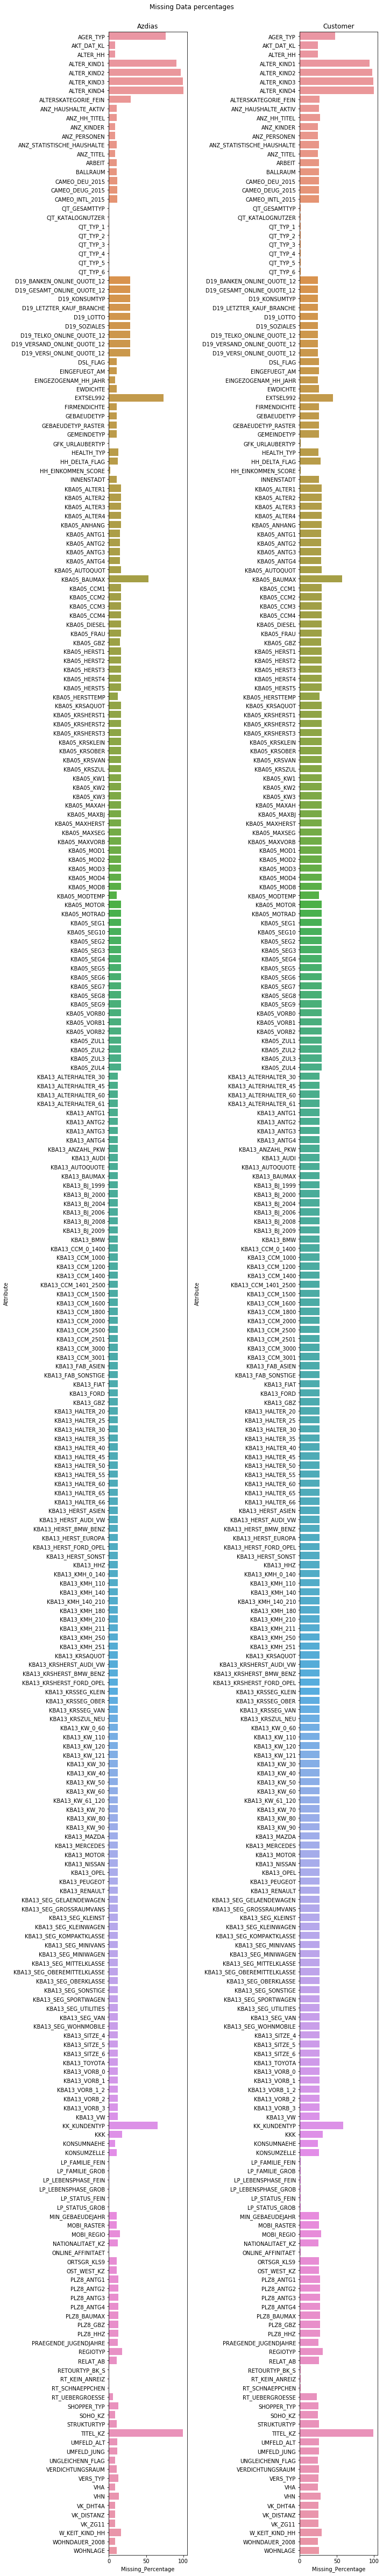

In [41]:
plot_percentage_missing(azdias_missing_report, customer_missing_report, percentage=0)

* By looking at the plot above we can conclude what percentage of data is missing from each column where we have missing data. 
* There is overlap in both **Azdias** and **Customers** data i.e. data is missing from same columns.
* Also the percentage of missing values in **Azdias** and **Customers** coincide a lot, which confirms that customers data is a subset of azdias data.

We can threshold the missing percentage and see how many columns have missing data percentage more than the threshold.

**Note**:
 After testing multiple values of threshold 30 seems to be giving good results in terms of less columns to be removed and almost same number of columns to be removed from both dataframes.

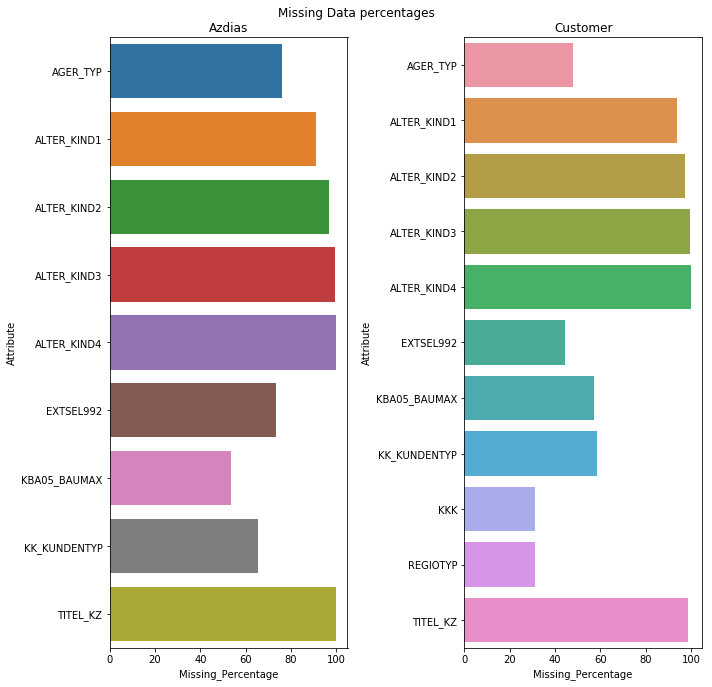

In [42]:
plot_percentage_missing(azdias_missing_report, customer_missing_report, percentage=30, figsize=(10, 10))

* We have *11* features with more more than 30% missing values in **Customer** data, where as in **Azdias** data we only have *9* feature. Whereas, in total we had *279* columns with missing values in both dataframes. 
* So *11* and *9* are considerably less nuzmber of features when compared to *279* and we can drop them. 

We are going to remove the features with more than 30% of data from **Customer** data, also the same features have to be removed from **Azdias** data.

In [8]:
def remove_missing_columns(df1, df2, df1_missing, df2_missing, threshold=30):
    """
    Drops columns from df1 and df2 with given threshold.
    
    Uses df1_missing and df2_missing to determing which columns to remove.
    If df1_missing has more missing columns (missing_percentage > threshold),
    then df1_missing is taken as reference and vice versa.
    """
    
    removable_cols1 = df1_missing[df1_missing.Missing_Percentage > threshold]
    removable_cols2 = df2_missing[df2_missing.Missing_Percentage > threshold]
    
    if len(removable_cols1) > len(removable_cols2):
        remove_cols = removable_cols1.Attribute.tolist()
    else:
        remove_cols = removable_cols2.Attribute.tolist()
        
    print("Number of columns Before dropping")
    print(f"df1 - {len(df1.columns)}")
    print(f"df2 - {len(df2.columns)}")
        
    print(f"Removing {len(remove_cols)} from given dataframes")
    df1 = df1.drop(remove_cols, axis = 1)
    df2 = df2.drop(remove_cols, axis = 1)
    
    print("Number of columns After dropping")
    print(f"df1 - {len(df1.columns)}")
    print(f"df2 - {len(df2.columns)}")
    
    return (df1, df2)

In [51]:
azdias, customers = remove_missing_columns(azdias, customers, customer_missing_report, azdias_missing_report)

Number of columns Before dropping
df1 - 366
df2 - 369
Removing 11 from given dataframes
Number of columns After dropping
df1 - 355
df2 - 358


#### Missing values Row-wise

After removing the columns which have more than 30% missing values, now we can look at the dataframes with remaining features for any missing values in rows.

In [127]:
def plot_missing_rowwise_histogram(df1, df2, bins=30, figsize=(10,6)):
    """
    Takes in two dataframes and plots a barchart comparing two dataframes
    rows and percentage of missing values based on a threshold percentage given
    """
    bins = 30
    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot(111)
    ax.set_title("No. of Rows vs No. of Missing features")
    ax.set_xlabel("No. of Missing Features")
    ax.set_ylabel("No. of Rows")
    sns.distplot(df1.isnull().sum(axis=1), bins, kde=False, ax=ax, label="Azdias")
    sns.distplot(df2.isnull().sum(axis=1), bins, kde=False, ax=ax, label="Customers")
    ax.legend()
    
    plt.show()

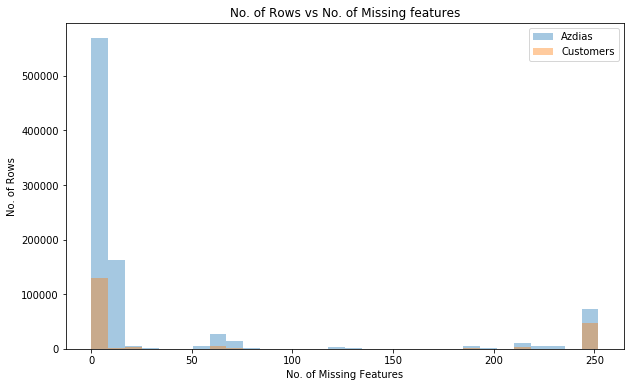

In [128]:
plot_missing_rowwise_histogram(azdias, customers)

From the above plot we can conclude,
* We have *250/355* features missing in approximately *70000* rows in **Azdias** and approximately *50000* rows in **Customers** data.
* Most of the rows have less than 50 missing values in both dataframes.
* **Customers** data has comparatively more missving rows than **Azdias**.

Now we can drop all the rows which have more than 50 missing values.

In [9]:
def remove_missing_rows(df, threshold):
    """
    Takes in a dataframe and drops rows with number of missing features 
    as per given threshold.
    """
    
    df = df.dropna(thresh=df.shape[1]-threshold)
    
    # Reset index
    df = df.reset_index()
    del df['index']
    
    return df

In [147]:
print("Number of rows in Azdias before dropping rows - ", len(azdias))
print("Number of rows in Customers before dropping rows - ", len(customers))

Number of rows in Azdias before dropping rows -  891221
Number of rows in Customers before dropping rows -  191652


In [149]:
customers = remove_missing_rows(customers, threshold=50)
azdias = remove_missing_rows(azdias, threshold=50)

In [150]:
print("Number of rows in Azdias after dropping rows - ", len(azdias))
print("Number of rows in Customers after dropping rows - ", len(customers))

Number of rows in Azdias after dropping rows -  737288
Number of rows in Customers after dropping rows -  134246


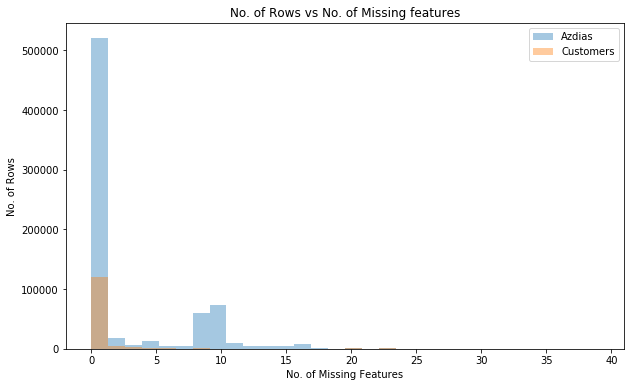

In [151]:
plot_missing_rowwise_histogram(azdias, customers)

As seen in the above plot we have successfully removed all the rows having more than 50 missing features. But, we still have some missing values in range of *1* to *50*. We can impute most common values of corresponding features in these rows, as the data represents the demographics of population. We can make an assumption that these missing values will be equal to the most common ones.

Before that, we can build a function to perform what we have done until now.

In [29]:
def get_cleaned_data(azdias, customers, attributes_values, column_miss_perc=30, row_miss_count=50):
    
    extra_cols_in_customers = [col for col in customers.columns if col not in azdias.columns]
    
    # Forward fill attribute_values dataframe, to access required columns and corresponding info
    attributes_values["Attribute"] = attributes_values["Attribute"].ffill()
    
    # Fixing columns 18 and 19
    print("Fixing 18, 19 columns")
    warning_cols = list(azdias.columns[18:20])
    
    # Ignore if these cols are already cleaned 
    if not (customers[warning_cols[0]].dtype == 'float64') & (customers[warning_cols[1]].dtype == 'float64'):
        customers = fix_cameo_cols(customers)
    if not (azdias[warning_cols[0]].dtype == 'float64') & (azdias[warning_cols[1]].dtype == 'float64'):
        azdias = fix_cameo_cols(azdias)
    
    # Replacing "Unkown" values with "np.nan"
    print("Replacing 'unkown' values with 'NaN'")
    unkown_attributes_values = attributes_values[attributes_values["Meaning"] == "unknown"]
    
    azdias = replace_unkowns(azdias, unkown_attributes_values, verbose=False)
    customers = replace_unkowns(customers, unkown_attributes_values, verbose=False)
    
    # Missing Values
    
    # Columns with missing values
    print(f"Removing columns with more than {column_miss_perc} % missing values")
    customer_missing_report = get_missing_report(customers)
    azdias_missing_report = get_missing_report(azdias)
    
    azdias, customers = remove_missing_columns(azdias, customers, 
                                               customer_missing_report,
                                               azdias_missing_report,
                                              threshold=column_miss_perc)
    
    # Rows with missing values
    print(f"Removing rows with more than {row_miss_count} missing values")
    customers = remove_missing_rows(customers, threshold=row_miss_count)
    azdias = remove_missing_rows(azdias, threshold=row_miss_count)
    
    return azdias, customers

In [30]:
azdias, customers = get_cleaned_data(azdias, customers, attributes_values)

Fixing 18, 19 columns
Replacing 'unkown' values with 'NaN'
Removing columns with more than 30 % missing values
Number of columns Before dropping
df1 - 366
df2 - 369
Removing 11 from given dataframes
Number of columns After dropping
df1 - 355
df2 - 358
Removing rows with more than 50 missing values


In [31]:
print("Azdias shape -",azdias.shape)
print("Customers shape -",customers.shape)

Azdias shape - (737288, 355)
Customers shape - (134246, 358)


In [32]:
azdias.to_csv('./data/Azdias_cleaned.csv', index=False)
customers.to_csv('./data/Customers_cleaned.csv', index=False)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')